### 3.3 Pre-entrenamiento

En esta seccióon se utilizará un AE para pre-entrenar redes profundas. El efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros. Cabe destacar que todo los resultados expuestos a continuación, fueron obtenidos por medio del uso de GPU (como ha sido la tónica a lo largo de toda la experiencia). Se hace uso de las siguientes librerías:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pickle
import time

from numpy.random import binomial
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Input, Dense, Activation
from keras.optimizers import SGD
from keras.objectives import binary_crossentropy
from keras.utils import np_utils
from keras.models import Model, load_model, save_model, Sequential

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


Se carga y pre-procesa el data set de igual manera que en la secciones _3.1_ y _3.2_:

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalizacion de imagenes
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Transformación en vectores R^{784}
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Creación conjunto de validación
nval = 5000
x_val = x_train[-nval:]
y_val = y_train[-nval:]
x_train = x_train[:-nval]
y_train = y_train[:-nval]

# Transformación de salidas a probabilidades de activación
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Y la respectiva función para visualización de resultados:

In [1]:
def history_plot(hist_list, labels, n_epoch=20, title=None):
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax.set_xticks(np.linspace(1,n_epoch+1,20))
    #ax.set_yticks(np.linspace(0,1,10))
    plt.xlim(0,n_epoch+1)
    if title is not None: plt.title(title)
    for i,hist in enumerate(hist_list):
        plt.plot(range(1,n_epoch+1), hist['val_loss'][0:n_epoch], 'o-', label=labels[i])
    plt.legend(loc=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('val_loss')
    plt.grid()
    plt.show()

***a)*** Inicialmente se entrena una red FF para clasificar las imágenes de MNIST. Se emplea SGD básico con tasa de aprendizaje fija $\eta = 1$ y 50 epochs. Se utiliza una arquitectura $784 \times 1000 \times 1000 \times 10$ y funciones de activación sigmoidales. Se procede a determinar el error de clasificación alcanzado por el modelo en el conjunto de test, sin el empleo de pre-entrenamiento por medio de AE's.

In [3]:
input_img = Input(shape=(784,))

n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'sigmoid'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10010     
Total params: 1,796,010.0
Trainable params: 1,796,010
Non-trainable params: 0.0
_________________________________________________________________


Se procede a entrenar (vía GPU):

In [ ]:
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=epochs_, batch_size=25,shuffle=True, validation_data=(x_val, Y_val), verbose=1)
model.save('entrenamientos/SigmoidNet784x1000x1000x10-50epochs.h5')

In [ ]:
# Carga de history del modelo entrenado previamente
model1 = load('entrenamientos/SigmoidNet784x1000x1000x10-50epochs');
model1.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history1 = pickle.load( open('entrenamientos/SigmoidNet784x1000x1000x10-50epochs.hist', 'rb') )

A continuación, se visualiza la pérdida en función de los ciclos de entrenamiento:

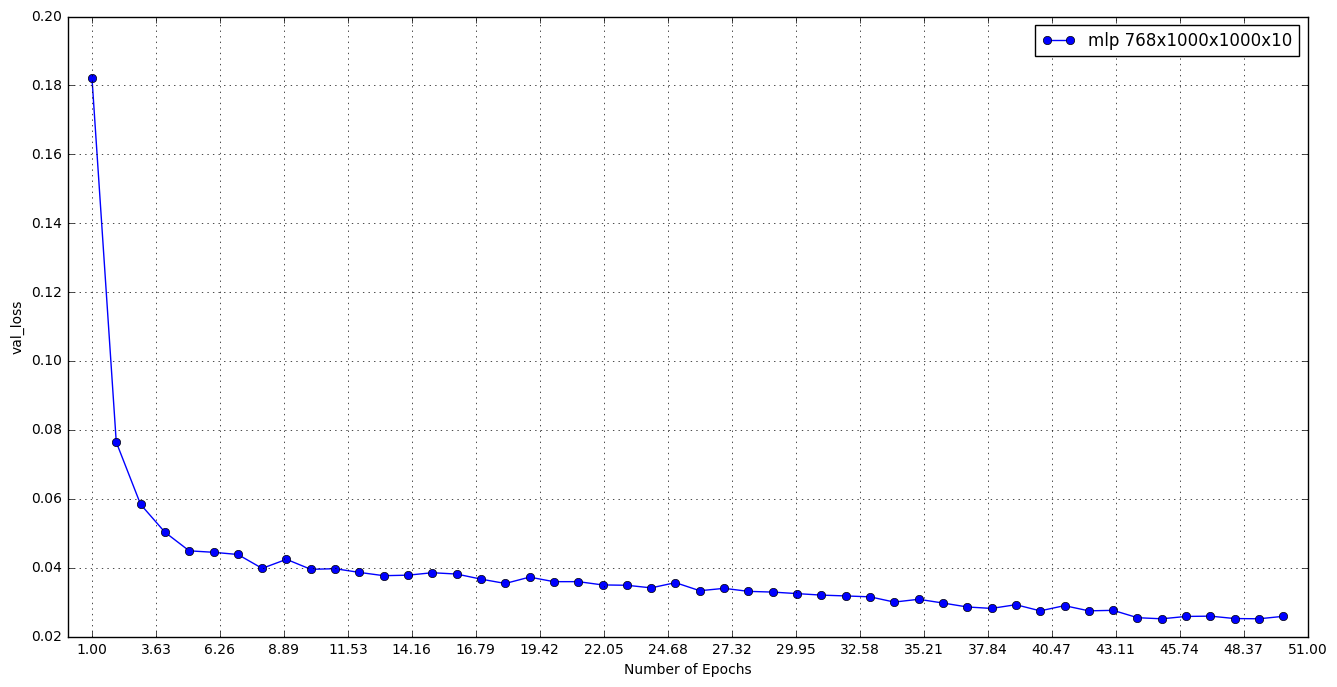

In [107]:
history_plot([history1], ['mlp 768x1000x1000x10'], n_epoch=50)

Es posible apreciar un rápido entrenamiento en las primeras epochs, el cual parece converger a un mínimo local dentro del vecindario en que se encuentra una función de pérdida igual a 0.0122 en el conjunto de validación al finalizar las 50 epochs de entrenamiento.

En cuanto a las métricas alcanzadas por el conjuntos de pruebas:

In [13]:
loss,acc = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss: {0}'.format(loss)); print('Test accuracy: {0}'.format(acc))

Test loss: 0.030929651294089852
Test accuracy: 0.990139995765686


In [11]:
print ('Error de clasificacion en conjunto de test:', (1 - 0.990139995765686) * 100,'%')

Error de clasificacion en conjunto de test: 0.986000423431399 %


Así, se determina un error de clasificación alcanzado por el modelo en el conjunto de test igual a $0.986000423431399\%$. Resulta ser un error medianamente competitivo, implicando un desafío de igualmanera el superarlo (experimentación realizada en ítems posteriores) con modelos pre-entrenados con AE's.  

***b)*** A continuación, se construye y entrena una red neuronal profunda para clasificar las imágenes de MNIST utilizando la
arquitectura propuesta en a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Se proceda en modo clásico, es decir, entrenando en modo no-supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento se efectúa un entrenamiento supervisado convencional (finetunning).

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'sigmoid'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val, x_val))
autoencoder1.save('entrenamientos/3_3/Sigmoid_autoencoder_layer1_ae.h5')
encoder1.save('entrenamientos/3_3/Sigmoid_encoder_layer1_ae.h5')

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('entrenamientos/3_3/Sigmoid_autoencoder_layer2_ae.h5')
encoder2.save('entrenamientos/3_3/Sigmoid_encoder_layer2_ae.h5')

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Sigmoid_784x1000x1000x10_no_finetunning_ae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_ae.h5')

In [16]:
# Carga de history del modelo entrenado previamente
model20 = load('entrenamientos/3_3/Sigmoid_784x1000x1000x10_no_finetunning_ae');
model21 = load('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_ae');
model20.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model21.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history2 = pickle.load( open('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_ae.hist', 'rb') )

Y se grafica la función de pérdida versus el epoch de entrenamiento (notar que en este caso solo se entrena la red densa por 20 epochs):

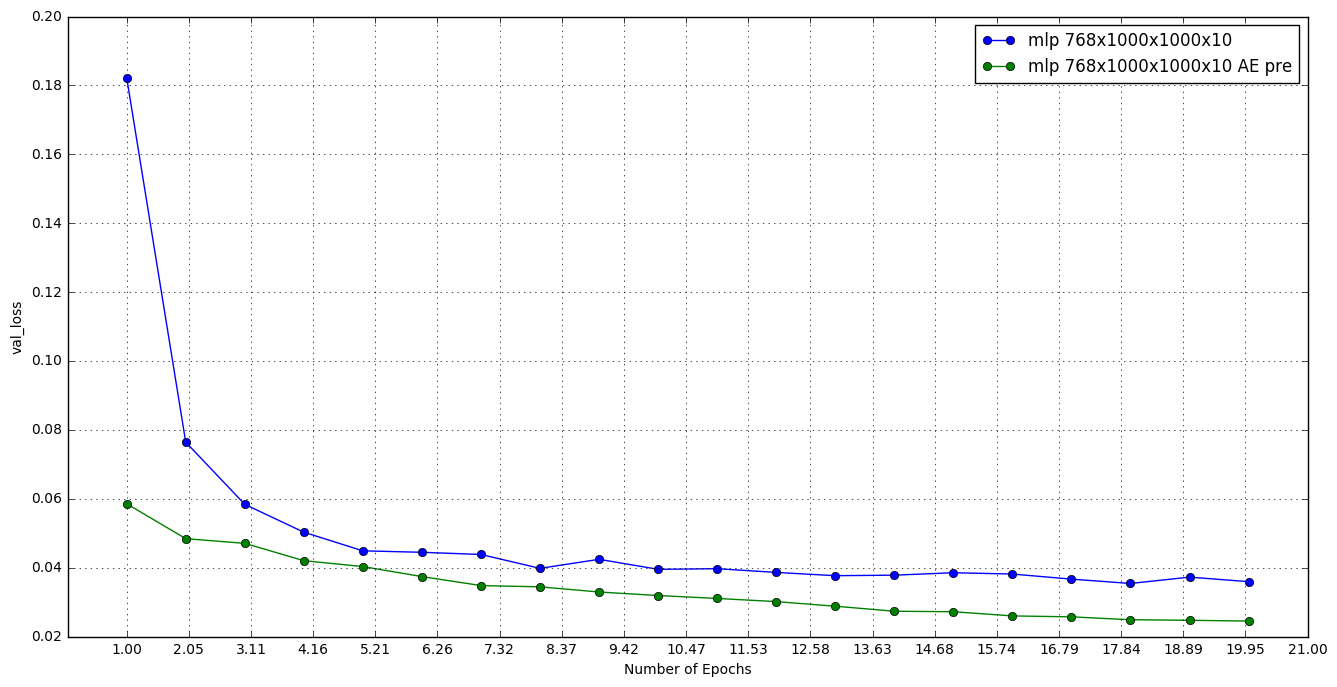

In [109]:
history_plot([history1, history2], ['mlp 768x1000x1000x10', 'mlp 768x1000x1000x10 AE pre'], n_epoch=20)

Se observa que el pre-entrenamiento de la red FF vía AE's, sitúa el modelo en un mejor punto de partida en el espacio de parámetros que minimizan la función de pérdida, esto es, se inicia el entrenamiento más cerca del conjunto de parámetros óptimos (locales), y por tanto se le permite alcanzar mejores soluciones con menor cantidad de epochs.

A continuación, se exponen tanto el error sobre el conjunto de test para la red pre-entrenada previa al finetunning como el error sobre el conjunto de test posterior al proceso de finetunning.

In [18]:
loss,acc = model20.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model21.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.3336046578884125
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.02932350579686463
Test accuracy: 0.9903899961471557 



In [12]:
print ('Error de clasificacion en conjunto de test:', (1 - 0.9903899961471557) * 100,'%')

Error de clasificacion en conjunto de test: 0.9610003852844273 %


Se aprecia un accuracy bastante competitivo ya en la fase previa del finetunning, sugiriendo que el pre-entrenamiento representa un buen mecanismo para el aprendizaje de la red. Notar además, que el desempeño después del finetunning es similar al obtenido por la red FF convencional, con la diferencia fundamental que la red pre-entrenada sólo efectuó 20 epochs para coseguirlo (frente a las 50 epochs realizadas para el entrenamiento de la red FF).

***c)*** A continuación, se repite el procedimiento realizado en b), pero esta vez se evalúa la utilidad de pre-entrenar la red FF por medio de _denoising AE's_. Se decide emplear un dAE con ruido _gaussiano_ de $\sigma=0.1$ para este cometido:

In [ ]:
def gaussian_noise(X_train, X_val, X_test, devst=0.1):
    noise_mask = devst*np.random.standard_normal(size=X_train.shape)
    X_train_noisy = X_train + noise_mask
    noise_mask = devst*np.random.standard_normal(size=X_val.shape)
    X_val_noisy = X_val + noise_mask
    noise_mask = devst*np.random.standard_normal(size=X_test.shape)
    X_test_noisy = X_test + noise_mask
    return X_train_noisy, X_val_noisy, X_test_noisy

Y se procede a definir y entrenar el modelo:

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'sigmoid'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

x_train_noisy, x_val_noisy, x_test_noisy = gaussian_noise(x_train, x_val, x_test)

### DENOISING AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train_noisy, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_noisy, x_val))
autoencoder1.save('entrenamientos/3_3/Sigmoid_autoencoder_layer1_dae.h5')
encoder1.save('entrenamientos/3_3/Sigmoid_encoder_layer1_dae.h5')

### DENOISING AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
x_train_noisy_encoded1, x_val_noisy_encoded1, x_test_noisy_encoded1 = gaussian_noise(x_train_encoded1, x_val_encoded1,
                                                                                     x_test_encoded1)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_noisy_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_noisy_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('entrenamientos/3_3/Sigmoid_autoencoder_layer2_dae.h5')
encoder2.save('entrenamientos/3_3/Sigmoid_encoder_layer2_dae.h5')

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Sigmoid_784x1000x1000x10_no_finetunning_dae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_dae.h5')

In [ ]:
# Carga de history del modelo entrenado previamente
model30 = load('entrenamientos/3_3/Sigmoid_784x1000x1000x10_no_finetunning_dae');
model31 = load('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_dae');
model30.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model31.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history2 = pickle.load( open('entrenamientos/3_3/Sigmoid_784x1000x1000x10_finetunning_dae.hist', 'rb'))

Los resultados expuestos a continuación muestran que el uso de dAE's no provee una mejora sustantiva a aquellos obtenidos con anterioridad sobre el conjunto de imágenes de MNIST. Por el contrario, compite muy de cerca con los resultados del AE normal, consiguiendo una curva de función de pérdida prácticamente equivalente.

In [22]:
loss,acc = model30.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model31.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.3395186320781708
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.029282233668118714
Test accuracy: 0.9903099973678589 



In [13]:
print ('Error de clasificacion en conjunto de test:', (1 - 0.9903099973678589) * 100,'%')

Error de clasificacion en conjunto de test: 0.9690002632141148 %


Así, se concluye empíricamente que el error de clasificación conseguido por pre-entremaiento vía dAE sobre MNIST es incluso ligeramente mayor que el obtenido en b) (por ende es sustancialmente más competitivo que el obtenido en a)), sugiriendo que estos no permitirían la generación de representaciones más robustas del patrón de entrada como se esperaría, sino que únicamente contribuiría en un entorpecimiento de la reconstrucción (conjutura débil al no conocer los respectivos pesos que los AE's facilitan a la red FF pre-entrenada).

***d)*** Finalmente, se repite lo realizado en a), b) y c) con distintas funciones de activación: _Tanh_ y _ReLu_.



_i) Red FF sin pre-entrenamiento:_

In [ ]:
#Todo ejecutado en GPU
input_img = Input(shape=(784,))

n_hidden_layer1 = 1000
activation_layer1 = 'relu'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'relu'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=epochs_, batch_size=25,shuffle=True, validation_data=(x_val, Y_val), verbose=1)
model.save('entrenamientos/ReluNet784x1000x1000x10-50epochs.h5')

n_hidden_layer1 = 1000
activation_layer1 = 'tanh'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'tanh'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=epochs_, batch_size=25,shuffle=True, validation_data=(x_val, Y_val), verbose=1)
model.save('entrenamientos/TanhNet784x1000x1000x10-50epochs.h5')

In [25]:
# Carga de history del modelo entrenado previamente
model4 = load('entrenamientos/ReluNet784x1000x1000x10-50epochs')
model4.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history4 = pickle.load( open('entrenamientos/ReluNet784x1000x1000x10-50epochs.hist', 'rb'))

model5 = load('entrenamientos/TanhNet784x1000x1000x10-50epochs')
model5.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history5 = pickle.load( open('entrenamientos/TanhNet784x1000x1000x10-50epochs.hist', 'rb'))

Se procede a graficar los resultados:

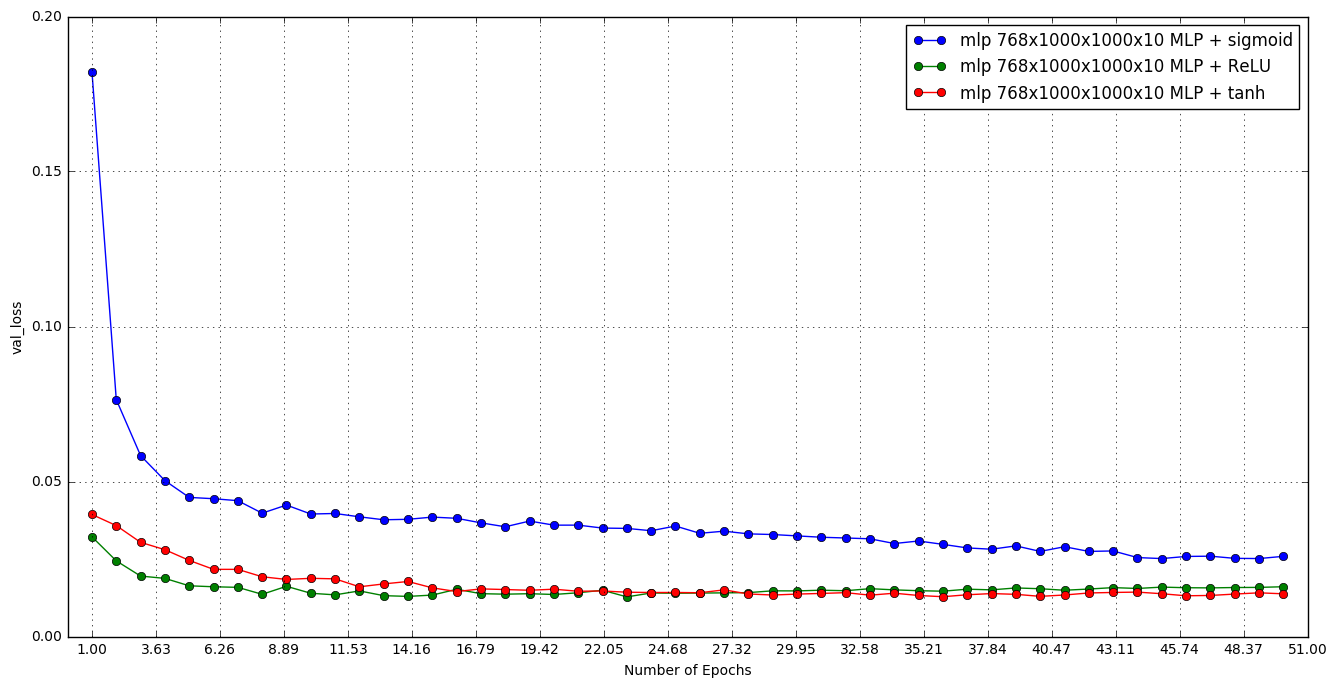

In [86]:
history_plot([history1, history6, history7], ['mlp 768x1000x1000x10 MLP + sigmoid',
            'mlp 768x1000x1000x10 MLP + ReLU', 'mlp 768x1000x1000x10 MLP + tanh'], n_epoch=50)

El gráfico refleja con _ReLu_ y _Tanh_ un desempeño superior al obtenido por _Sigmoid_. Se hipotetiza que el lento decaimiento de la función de pérdida es reflejo del fenómeno conocido como _vanishing gradients_ que hiere la óptima progpagación del gradiente.

In [26]:
loss,acc = model4.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model5.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.011682761193952501
Test accuracy: 0.9964599956512451 

Tanh results
Test loss: 0.011347551679700701
Test accuracy: 0.9962699954986572 



In [14]:
print ('Error de clasificacion en conjunto de test, por ReLu:', (1 - 0.9964599956512451) * 100,'%')
print ('Error de clasificacion en conjunto de test, por Tanh:', (1 - 0.9962699954986572) * 100,'%')

Error de clasificacion en conjunto de test, por ReLu: 0.35400043487548993 %
Error de clasificacion en conjunto de test, por Tanh: 0.3730004501342754 %


Así, se consiguen los dos errores de clasificación más bajos sobre el conjunto de pruebas, demostrando la superioridad de ambas funciones de activación por sobre _Sigmoid_ (en particular ReLu obtiene un resultado muy competitivo sin requerir pre-entrenamiento).

_ii) Red FF con pre-entrenamiento vía AE's:_

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'relu'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'relu'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val, x_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Relu_784x1000x1000x10_no_finetunning_ae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Relu_784x1000x1000x10_finetunning_ae.h5')

## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'tanh'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val, x_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Tanh_784x1000x1000x10_no_finetunning_ae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Tanh_784x1000x1000x10_finetunning_ae.h5')

In [27]:
# Carga de history del modelo entrenado previamente
model5 = load('entrenamientos/Relu_784x1000x1000x10_finetunning_ae')
model5.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history5 = pickle.load( open('entrenamientos/Tanh_784x1000x1000x10_finetunning_ae.hist', 'rb'))

model6 = load('entrenamientos/Tanh_784x1000x1000x10_finetunning_ae')
model6.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history6 = pickle.load( open('entrenamientos/Relu_784x1000x1000x10_finetunning_ae.hist', 'rb'))

Se procede a graficar los resultados:

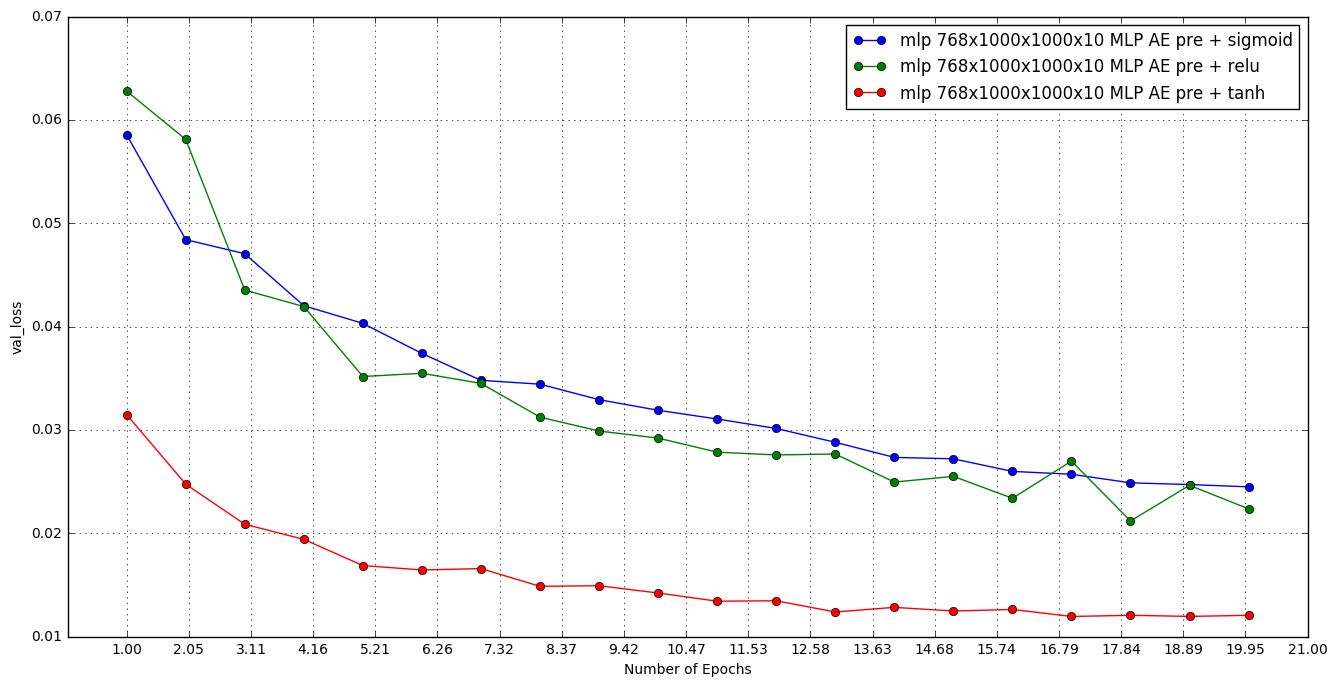

In [88]:
history_plot([history2, history8, history9], ['mlp 768x1000x1000x10 MLP AE pre + sigmoid', 
            'mlp 768x1000x1000x10 MLP AE pre + relu', 'mlp 768x1000x1000x10 MLP AE pre + tanh'], n_epoch=20)

Se aprecia una mejoría en desempeño con respecto al caso carente de pre-entrenamiento para funciones de activación _Sigmoid_ (como ya habíamos corroborado con anterioridad) y _Tanh_. Se acortan distancias entre rendimientos de _Sigmoid_ y _ReLu_. _Tanh_ se distancia positivamente de sus semejantes.

In [28]:
loss,acc = model5.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model6.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.02487821425013244
Test accuracy: 0.9918799962043762 

Tanh results
Test loss: 0.010894658477493794
Test accuracy: 0.9964399950027466 



In [15]:
print ('Error de clasificacion en conjunto de test, por ReLu:', (1 - 0.9918799962043762) * 100,'%')
print ('Error de clasificacion en conjunto de test, por Tanh:', (1 - 0.9964399950027466) * 100,'%')

Error de clasificacion en conjunto de test, por ReLu: 0.8120003795623831 %
Error de clasificacion en conjunto de test, por Tanh: 0.35600049972533965 %


Se corrobora de esta forma el buen desempeño que tiene la función _Tanh_ en la configuración con pre-entrenamiento. Se aprecia incluso un peor error en el caso de _ReLu_.

_iii) Red FF con pre-entrenamiento vía dAE's:_

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'relu'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'relu'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

x_train_noisy, x_val_noisy, x_test_noisy = gaussian_noise(x_train, x_val, x_test)

### DENOISING AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train_noisy, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_noisy, x_val))

### DENOISING AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
x_train_noisy_encoded1, x_val_noisy_encoded1, x_test_noisy_encoded1 = gaussian_noise(x_train_encoded1, x_val_encoded1,
                                                                                     x_test_encoded1)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_noisy_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_noisy_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Relu_784x1000x1000x10_no_finetunning_dae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Relu_784x1000x1000x10_finetunning_dae.h5')

## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'tanh'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

x_train_noisy, x_val_noisy, x_test_noisy = gaussian_noise(x_train, x_val, x_test)

### DENOISING AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train_noisy, x_train, epochs=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(x_val_noisy, x_val))

### DENOISING AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
x_train_encoded1 = encoder1.predict(x_train) 
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
x_train_noisy_encoded1, x_val_noisy_encoded1, x_test_noisy_encoded1 = gaussian_noise(x_train_encoded1, x_val_encoded1,
                                                                                     x_test_encoded1)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_noisy_encoded1, x_train_encoded1, epochs=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(x_val_noisy_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
model.save('entrenamientos/3_3/Tanh_784x1000x1000x10_no_finetunning_dae.h5')
model.fit(x_train, Y_train, epochs=20, batch_size=25, shuffle=True, validation_data=(x_val, Y_val))
model.save('entrenamientos/3_3/Tanh_784x1000x1000x10_finetunning_dae.h5')

In [31]:
# Carga de history del modelo entrenado previamente
model7 = load('entrenamientos/3_3/Relu_784x1000x1000x10_finetunning_dae')
model7.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history7 = pickle.load( open('entrenamientos/3_3/Relu_784x1000x1000x10_finetunning_dae.hist', 'rb') )

model8 = load('entrenamientos/3_3/Tanh_784x1000x1000x10_finetunning_dae')
model8.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history8 = pickle.load( open('entrenamientos/3_3/Tanh_784x1000x1000x10_finetunning_dae.hist', 'rb') )

Se procede a graficar los resultados:

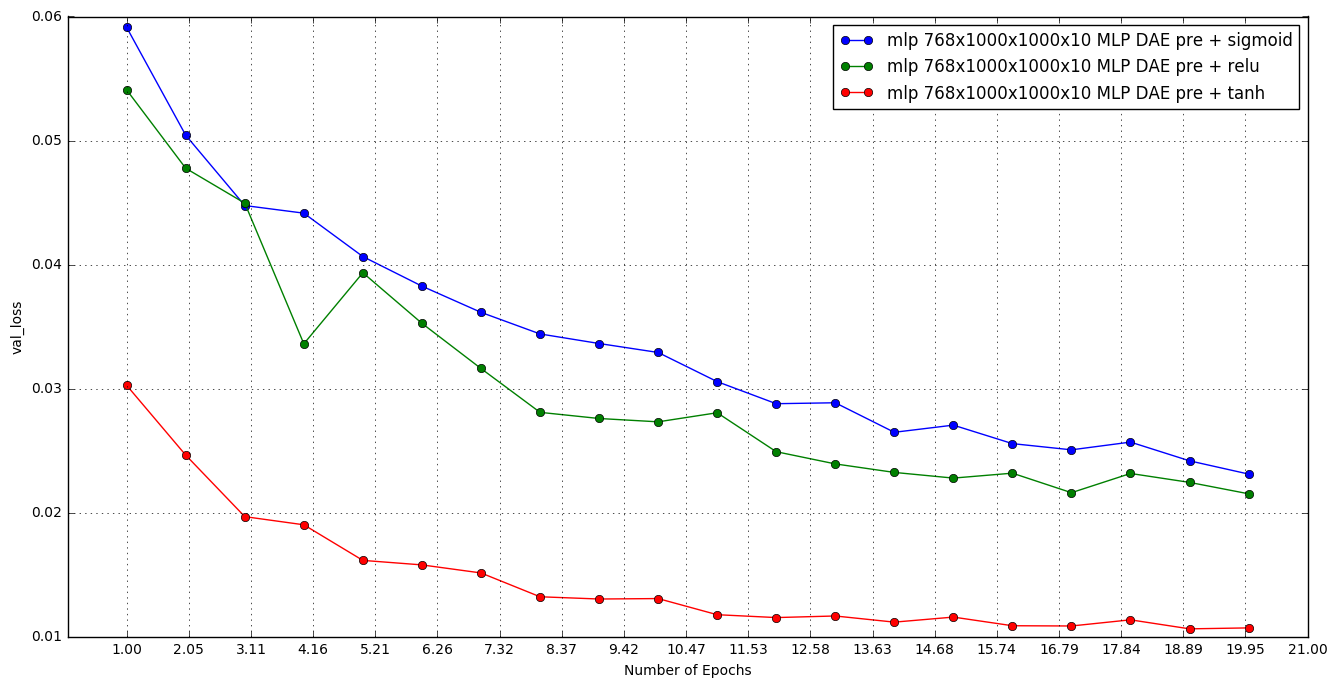

In [92]:
history_plot([history4, history12, history13], ['mlp 768x1000x1000x10 MLP DAE pre + sigmoid',
            'mlp 768x1000x1000x10 MLP DAE pre + relu', 'mlp 768x1000x1000x10 MLP DAE pre + tanh'], n_epoch=20)

Los resultados sobre el conjunto de entrenamiento no presentan grandes variaciones con las obtenidas con anterioridad.

In [33]:
loss,acc = model12.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model13.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.02568165319273248
Test accuracy: 0.9914199974060058 

Tanh results
Test loss: 0.011926016186346533
Test accuracy: 0.9956899967193603 



In [16]:
print ('Error de clasificacion en conjunto de test, por ReLu:', (1 - 0.9914199974060058) * 100,'%')
print ('Error de clasificacion en conjunto de test, por Tanh:', (1 - 0.9956899967193603 ) * 100,'%')

Error de clasificacion en conjunto de test, por ReLu: 0.8580002593994163 %
Error de clasificacion en conjunto de test, por Tanh: 0.4310003280639685 %


Probablemente una de las conclusiones más poderosas de este ítem resulta de la demostración empírica de una de las principales motivaciones del uso de _ReLu_ como función de activación estándar en la actualidad: el uso de _rectifer unit_ implicaría una disminución de la brecha existente entre aprendizajes con y sin pre-entrenamiento, y es que no se observan mejoras al incluir AE's en el proceso con respecto al obtenido por medio de una red FF convencional, incluso observando una función de pérdida mayormente minimizada en este último caso. Notar que las curvas para la función de pérdida obtenidas al aplicar no-linealidad por medio de _ReLu_ y _Tanh_ son extremadamente similares en el caso de privar a la red FF de pre-entrenamiento, situación que es modificada al incluir pre-entrenamiento, caso en que _Tanh_ potencia su rendimiento, calificándose como la función de activación con mejores resultados para una tarea de clasificación visual del dataset MNIST.

Por otro lado, nuevamente resulta esquiva la posibilidad de demostrar empíricamente un efecto positivo resultante del empleo de _denoising AE's_ para el proceso de aprendizaje (por sobre el uso de AE's tradicionales).